### VAE

/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


49.91412743326823
43.16422635294597
41.53451671142578
40.80478375854492
40.41446860148112
40.14255308024089
39.96481449788411
39.83697710571289
39.691762670898434
39.633132798258465
39.54533470052083
39.45176337076823
39.383196095784506
39.355101839192706
39.303584865315756
39.24027668863932
39.200607287597656
39.17248408203125
39.11604305623372
39.12999174194336
39.09192478027344
39.00873671875
39.02517587381999
38.97487121785482
38.961573075358075
38.96793815511068
38.94550854695638
38.92543028971354
38.90326215616862
38.91514118041992


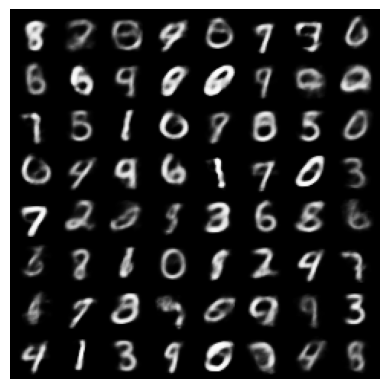

In [1]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


# hyperparameters
input_dim = 784  # mnist image 28x28
hidden_dim = 100
latent_dim = 20
epochs = 30
learning_rate = 1e-3
batch_size = 32


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = - torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size


# dataset
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)


 # visualize generated images
with torch.no_grad():
    sample_size = 64
    z2 = torch.randn(sample_size, latent_dim)
    z1_hat = model.decoder2(z2)
    z1 = reparameterize(z1_hat, torch.ones_like(z1_hat))
    x = model.decoder1(z1)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()
